# Fundamental Feature Selection

In [5]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from scipy.stats import pearsonr
import polars as pl
import numpy as np
from tqdm import tqdm
from datetime import datetime
import os

train_splits = {
    "full" : pl.datetime(2023, 3, 1, 0, 0, 0),
    "last_12m" : pl.datetime(2023, 6, 1, 0, 0, 0),
    "last_9m" : pl.datetime(2023, 9, 1, 0, 0, 0),
    "last_3m" : pl.datetime(2024, 2, 1, 0, 0, 0),
    "last_6m": pl.datetime(2024, 12, 1, 0, 0, 0),
}

PATHS = {
    "TRAIN_PATH" :"./kaggle/kaggle/input/drw-crypto-market-prediction/train.parquet",
    "TEST_PATH" : "./kaggle/kaggle/input/drw-crypto-market-prediction/test.parquet",
    "SUBMISSION_PATH" : "/kaggle/input/drw-crypto-market-prediction/sample_submission.csv",
}

train_data = pl.read_parquet(PATHS["TRAIN_PATH"]).sort("timestamp", descending = False)
print(train_data)

shape: (525_887, 897)
┌─────────┬─────────┬─────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────────┐
│ bid_qty ┆ ask_qty ┆ buy_qty ┆ sell_qty ┆ … ┆ X889     ┆ X890     ┆ label    ┆ timestamp    │
│ ---     ┆ ---     ┆ ---     ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---          │
│ f64     ┆ f64     ┆ f64     ┆ f64      ┆   ┆ f64      ┆ f64      ┆ f64      ┆ datetime[ns] │
╞═════════╪═════════╪═════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════════╡
│ 15.283  ┆ 8.425   ┆ 176.405 ┆ 44.984   ┆ … ┆ 0.159183 ┆ 0.530636 ┆ 0.562539 ┆ 2023-03-01   │
│         ┆         ┆         ┆          ┆   ┆          ┆          ┆          ┆ 00:00:00     │
│ 38.59   ┆ 2.336   ┆ 525.846 ┆ 321.95   ┆ … ┆ 0.158963 ┆ 0.530269 ┆ 0.533686 ┆ 2023-03-01   │
│         ┆         ┆         ┆          ┆   ┆          ┆          ┆          ┆ 00:01:00     │
│ 0.442   ┆ 60.25   ┆ 159.227 ┆ 136.369  ┆ … ┆ 0.158744 ┆ 0.529901 ┆ 0.546505 ┆ 2023-03-01   │
│         ┆         ┆       

In [6]:
def get_cols_inf(df: pl.DataFrame) -> list[str]:
    """
    Returns a list of column names that contain any positive or negative infinity.
    """
    cols = []
    for col in df.columns:
        # df[col] is a Series; .is_infinite() → Boolean Series; .any() → Python bool
        try:
            if df[col].is_infinite().any():
                cols.append(col)
        except Exception:
            # if the column isn’t numeric, .is_infinite() might error—just skip it
            continue
    return cols

def get_nan_columns(df: pl.DataFrame) -> list[str]:
    """
    Returns a list of column names with any NaN/null values.
    """
    cols = []
    for col in df.columns:
        if df.select(pl.col(col).is_null().any()).item():
            cols.append(col)
    return cols

def get_cols_zerostd(df: pl.DataFrame) -> list[str]:
    """
    Returns a list of column names whose standard deviation is zero
    (or whose std returns None because all values are null).
    Non-numeric columns (e.g. datetime) are skipped.
    """
    cols = []
    for col, dtype in zip(df.columns, df.dtypes):
        # Only attempt std() on numeric dtypes
        if dtype.is_numeric():  
            # df[col] is a Series; .std() returns a Python float or None
            std_val = df[col].std()
            if std_val == 0.0 or std_val is None:
                cols.append(col)
    return cols


def feature_engineering(df: pl.DataFrame) -> pl.DataFrame:
    # Feature engineering
    df = df.with_columns([
        # bidask_ratio = bid_qty / ask_qty
        (pl.col("bid_qty") / pl.col("ask_qty")).alias("bidask_ratio"),

        # buysell_ratio = 0 if volume == 0 else buy_qty / sell_qty
        pl.when(pl.col("volume") == 0)
        .then(0)
        .otherwise(pl.col("buy_qty") / pl.col("sell_qty"))
        .alias("buysell_ratio"),

        # bidask_delta = bid_qty - ask_qty
        (pl.col("bid_qty") - pl.col("ask_qty")).alias("bidask_delta"),

        # buysell_delta = buy_qty - sell_qty
        (pl.col("buy_qty") - pl.col("sell_qty")).alias("buysell_delta"),

        # buysell_size = buy_qty + sell_qty
        (pl.col("buy_qty") + pl.col("sell_qty")).alias("buysell_size"),

        # bidask_size = bid_qty + ask_qty
        (pl.col("bid_qty") + pl.col("ask_qty")).alias("bidask_size"),
    ])
    return df
def preprocess_train(train: pl.DataFrame, columns_to_drop: list[str] = []) -> pl.DataFrame:
    """
    Mirror of the original pandas workflow, but using polars.
    1. Identify columns with infinite, NaN, or zero‐std and drop them.
    2. Drop any user‐specified columns (e.g. label or order‐book columns).
    3. (You can add normalized/scaling steps here if needed.)
    """
    df = train.clone()

    df = feature_engineering(df)
    
    #### Preprocessing
    cols_inf = get_cols_inf(df)
    print("Columns with infinite values:", cols_inf)

    cols_nan = get_nan_columns(df)
    print("Columns with NaN values:", cols_nan)

    cols_zerostd = get_cols_zerostd(df)
    print("Columns with zero standard deviation:", cols_zerostd)
    # Drop columns with infinite, NaN, or zero‐std values
    drop_columns = list(set(cols_inf) | set(cols_nan) | set(cols_zerostd) | set(columns_to_drop))
    if drop_columns:
        df = df.drop(drop_columns)
    # df = df.sort("timestamp", descending=False)
    return df, drop_columns

def preprocess_test(test: pl.DataFrame, columns_to_drop: list[str] = []) -> pl.DataFrame:
    df = test.clone()
    df = feature_engineering(df)
    df = df.drop(columns_to_drop)
    print("Columns dropped from test set:", columns_to_drop)
    return df



# 1 Selection Models

In [ ]:
y = train_data["label"]
X, drop_columns = preprocess_train(
    train_data,
    columns_to_drop=["label", "bid_qty", "ask_qty", "buy_qty", "sell_qty"]
)
print(X)

Columns with infinite values: ['X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716', 'X717']
Columns with NaN values: []
Columns with zero standard deviation: ['X864', 'X867', 'X869', 'X870', 'X871', 'X872']
shape: (525_887, 871)
┌─────────┬──────────┬───────────┬───────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ volume  ┆ X1       ┆ X2        ┆ X3        ┆ … ┆ bidask_del ┆ buysell_de ┆ buysell_s ┆ bidask_si │
│ ---     ┆ ---      ┆ ---       ┆ ---       ┆   ┆ ta         ┆ lta        ┆ ize       ┆ ze        │
│ f64     ┆ f64      ┆ f64       ┆ f64       ┆   ┆ ---        ┆ ---        ┆ ---       ┆ ---       │
│         ┆          ┆           ┆           ┆   ┆ f64        ┆ f64        ┆ f64       ┆ f64       │
╞═════════╪══════════╪═══════════╪═══════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 221.389 ┆ 0.121263 ┆ -0.41769  ┆ 0.005399  ┆ … ┆ 6.858  

**Principal Component Analysis (PCA)-based selection**

  1. Fit PCA on the centered feature matrix.
  2. Examine the loading matrix $L\in\mathbb R^{p\times k}$, where each column $L_j$ gives coefficients of the $j$ th principal component in the original feature basis.
  3. For each original feature $i$, compute its overall importance score, e.g.\ $\sum_{j=1}^k |L_{ij}|\times\lambda_j$, where $\lambda_j$ is the variance explained by component $j$.
  4. Select the top-$m$ features by that score or apply a threshold on absolute loading magnitude.


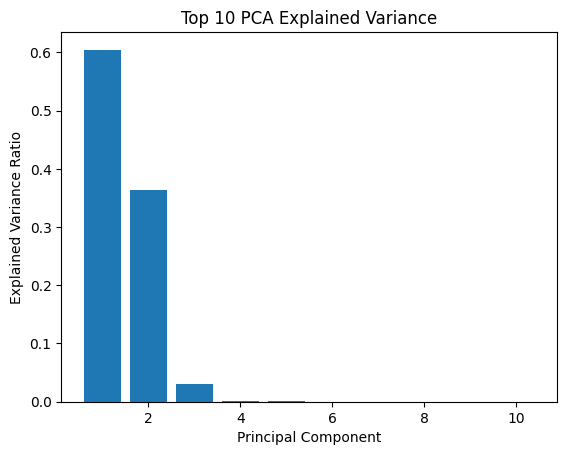

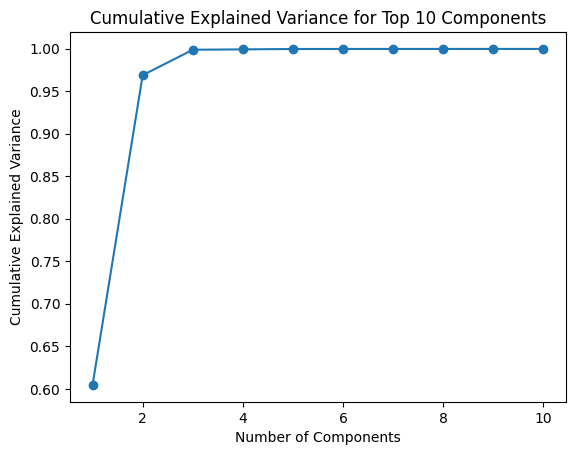

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def select_pca_features(X, m_components, n_top_features):
    """
    Perform PCA on X and select the top features based on loading scores.

    Parameters
    ----------
    X : pandas.DataFrame
        Feature matrix with shape (n_samples, n_features).
    m_components : int
        Number of principal components to retain for scoring.
    n_top_features : int
        Number of top features to select based on PCA scores.

    Returns
    -------
    selected_features : list of str
        Names of the selected top features.
    scores : numpy.ndarray
        Corresponding scores of the selected features.
    """
    pca = PCA(n_components=m_components)
    pca.fit(X)
    # Absolute loadings
    loadings = np.abs(pca.components_).T  # shape (n_features, m_components)
    # Score each feature by weighted sum of its loadings
    scores = loadings.dot(pca.explained_variance_ratio_)
    # Select top features
    feature_indices = np.argsort(scores)[::-1][:n_top_features]
    feature_names = X.columns[feature_indices]

    var_ratio = pca.explained_variance_ratio_
    indices = np.arange(1, m_components + 1)

    # Bar plot for individual explained variance
    plt.figure()
    plt.bar(indices, var_ratio)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title(f'Top {m_components} PCA Explained Variance')
    plt.show()

    # Line plot for cumulative explained variance
    cum_var = np.cumsum(var_ratio)
    plt.figure()
    plt.plot(indices, cum_var, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'Cumulative Explained Variance for Top {m_components} Components')
    plt.show()

    return feature_names.tolist(), scores[feature_indices]

# X_pandas = X.drop(["timestamp"]).to_pandas()
# selected, scores = select_pca_features(X_pandas, m_components=10, n_top_features=100)

* **Factor Analysis (FA)-based selection**

  1. Fit a common‐factor model to capture the shared covariance among features.
  2. Obtain the factor loading matrix $\Lambda\in\mathbb R^{p\times q}$ and communalities $h_i^2=\sum_{j}\Lambda_{ij}^2$.
  3. Use each feature’s communality $h_i^2$ as its importance (higher = more explained by common factors).
  4. Retain features with highest communalities up to your budget.



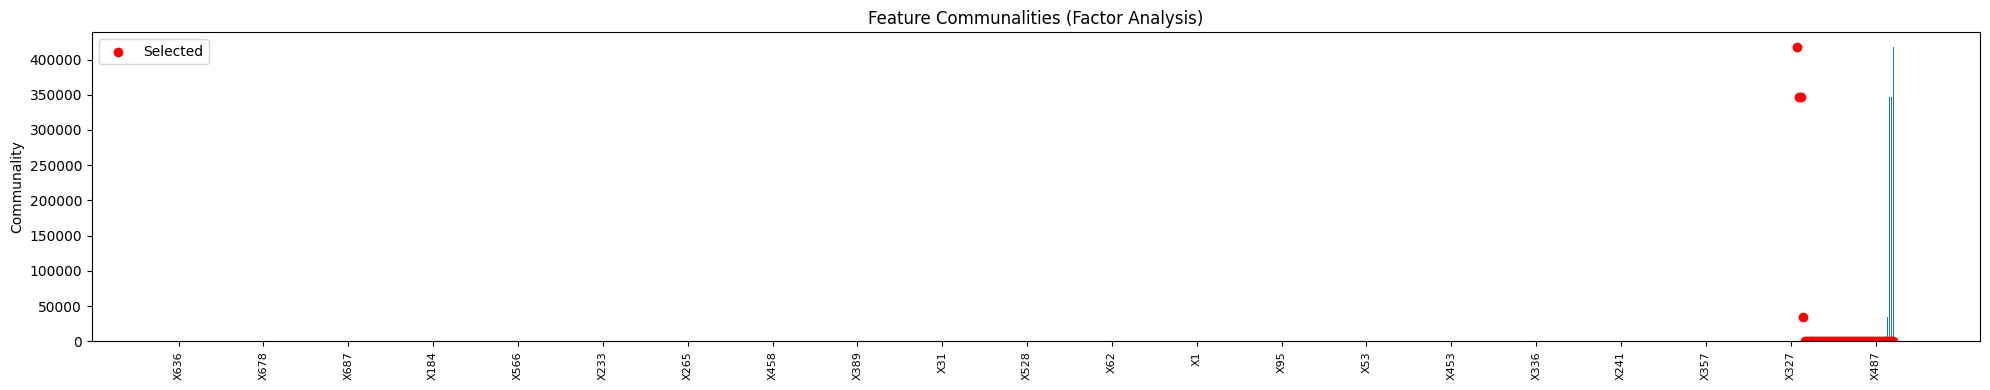

In [ ]:
from sklearn.decomposition import FactorAnalysis

def factor_analysis_select(X, n_factors, n_top_features):
    """
    Perform Factor Analysis on X and select top features based on communalities.
    Also plots communalities for all features, highlighting selected ones.

    Parameters
    ----------
    X : pandas.DataFrame
        Feature matrix with shape (n_samples, n_features).
    n_factors : int
        Number of latent factors to extract.
    n_top_features : int
        Number of top features to select based on communalities.

    Returns
    -------
    model : sklearn.decomposition.FactorAnalysis
        Fitted FactorAnalysis model.
    selected_features : list of str
        Names of the selected top features.
    """
    # Fit Factor Analysis
    fa = FactorAnalysis(n_components=n_factors, random_state=0)
    fa.fit(X)
    
    # Loadings and communalities
    loadings = fa.components_.T  # (n_features, n_factors)
    communalities = np.sum(loadings**2, axis=1)
    
    # Select top features
    feature_indices = np.argsort(communalities)[::-1][:n_top_features]
    selected_features = X.columns[feature_indices].tolist()
    
    # Prepare sorted indices for plotting
    sorted_idx = np.argsort(communalities)
    n_features = len(communalities)
    
    # Decide tick frequency to avoid overlap (aim for ~20 ticks max)
    max_ticks = 20
    step = max(1, n_features // max_ticks)
    tick_positions = np.arange(0, n_features, step)
    tick_labels = X.columns[sorted_idx][::step]
    
    # Plot communalities
    plt.figure(figsize=(20, 4))
    plt.bar(np.arange(n_features), communalities[sorted_idx])
    plt.scatter(np.where(np.in1d(sorted_idx, feature_indices))[0],
                communalities[feature_indices], color='red', label='Selected')
    plt.xticks(tick_positions, tick_labels, rotation=90, fontsize=8)
    plt.ylabel('Communality')
    plt.title('Feature Communalities (Factor Analysis)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return fa, selected_features

# fa_model, selected_fa = factor_analysis_select(X_pandas, n_factors=10, n_top_features=50)

**Independent Component Analysis (ICA)-based selection**

  1. Perform ICA to decompose features into statistically independent sources: $X = A\,S$.
  2. Use the absolute mixing‐matrix weights $|A_{i\,j}|$ as indications of how strongly feature $i$ contributes to source $j$.
  3. Aggregate per-feature scores, e.g.\ $\sum_j|A_{ij}|$, and select those above a threshold.

In [ ]:
from sklearn.decomposition import FastICA

def ica_feature_select(X, n_components, n_top_features):
    """
    Perform Independent Component Analysis on X and select top features based on mixing matrix weights.
    Also plots feature scores derived from the mixing matrix.

    Parameters
    ----------
    X : pandas.DataFrame
        Feature matrix with shape (n_samples, n_features).
    n_components : int
        Number of independent components to extract.
    n_top_features : int
        Number of top features to select based on ICA scores.

    Returns
    -------
    ica : sklearn.decomposition.FastICA
        Fitted ICA model.
    selected_features : list of str
        Names of the selected top features.
    """
    # Fit ICA
    ica = FastICA(n_components=n_components, random_state=0)
    S = ica.fit_transform(X)  # Reconstructed signals, not used directly
    mixing = ica.mixing_      # shape (n_features, n_components)

    # Compute feature scores: sum of absolute weights across components
    scores = np.sum(np.abs(mixing), axis=1)

    # Select top features by score
    feature_indices = np.argsort(scores)[::-1][:n_top_features]
    selected_features = X.columns[feature_indices].tolist()

    # Plot feature scores
    sorted_idx = np.argsort(scores)
    n_features = len(scores)

    # Limit tick labels to avoid overlap (~20 max)
    max_ticks = 20
    step = max(1, n_features // max_ticks)
    tick_positions = np.arange(0, n_features, step)
    tick_labels = X.columns[sorted_idx][::step]

    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(n_features), scores[sorted_idx])
    plt.scatter(np.where(np.in1d(sorted_idx, feature_indices))[0],
                scores[feature_indices], color='red', label='Selected')
    plt.xticks(tick_positions, tick_labels, rotation=90, fontsize=8)
    plt.ylabel('ICA Feature Score')
    plt.title('Feature Scores from ICA Mixing Matrix')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return ica, selected_features

# ica_model, top_feats = ica_feature_select(X_pandas, n_components=5, n_top_features=10)

TypeError: only integer scalar arrays can be converted to a scalar index

* **Canonical Correlation Analysis (CCA)-based selection**

  1. Given feature block $X$ and target $y$, form a second “block” $Y=y$ (or include engineered target lags).
  2. Solve for weight vectors $u,v$ that maximize $\mathrm{corr}(X u, Y v)$.
  3. The canonical weights $u_i$ indicate feature relevance; select features with largest $|u_i|$.


In [ ]:
from sklearn.cross_decomposition import CCA

def cca_feature_select(X, y, n_components, n_top_features):
    """
    Perform Canonical Correlation Analysis between X features and continuous target y,
    select top features based on canonical weight magnitudes, and plot their scores.

    Parameters
    ----------
    X : pandas.DataFrame
        Feature matrix of shape (n_samples, n_features).
    y : pandas.Series or numpy.ndarray
        Continuous target vector of shape (n_samples,).
    n_components : int
        Number of canonical components to compute.
    n_top_features : int
        Number of top features to select based on aggregate weight scores.

    Returns
    -------
    cca : sklearn.cross_decomposition.CCA
        Fitted CCA model.
    selected_features : list of str
        Names of the selected top features.
    """
    # Ensure y is 2D
    y_vec = y.values.reshape(-1, 1) if hasattr(y, 'values') else y.reshape(-1, 1)
    
    # Fit CCA
    cca = CCA(n_components=n_components)
    cca.fit(X, y_vec)
    
    # Extract X weights (features x components)
    weights = cca.x_weights_  # shape (n_features, n_components)
    
    # Score each feature by sum of absolute weights across components
    scores = np.sum(np.abs(weights), axis=1)
    
    # Select top features
    feature_indices = np.argsort(scores)[::-1][:n_top_features]
    selected_features = X.columns[feature_indices].tolist()
    
    # Plot feature scores
    sorted_idx = np.argsort(scores)
    n_features = len(scores)
    max_ticks = 20
    step = max(1, n_features // max_ticks)
    tick_positions = np.arange(0, n_features, step)
    tick_labels = X.columns[sorted_idx][::step]
    
    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(n_features), scores[sorted_idx])
    plt.scatter(np.where(np.in1d(sorted_idx, feature_indices))[0],
                scores[feature_indices], color='red', label='Selected')
    plt.xticks(tick_positions, tick_labels, rotation=90, fontsize=8)
    plt.ylabel('CCA Feature Score')
    plt.title('Feature Importances from CCA Weights')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return cca, selected_features

# cca_model, cca_selected = cca_feature_select(X_pandas, y.to_numpy(), n_components=5, n_top_features=10)

* **Correlation (Pearson) filter**

  1. Compute Pearson correlation $r_i = \mathrm{corr}(X_i, y)$ for each feature $X_i$.
  2. Rank by $|r_i|$ and choose top-$m$ features or those exceeding a predefined $|r|$ threshold.


* **Mutual Information (MI) filter**

  1. Estimate $I(X_i;y)$ nonparametrically (e.g. via k-nearest neighbors).
  2. Rank features by MI score and select the top fraction.



In [ ]:
from sklearn.feature_selection import mutual_info_regression

def mutual_info_filter(X, y, n_top_features):
    """
    Compute mutual information between each feature in X and continuous target y,
    select top features based on MI score, and plot the scores.

    Parameters
    ----------
    X : pandas.DataFrame
        Feature matrix of shape (n_samples, n_features).
    y : pandas.Series or numpy.ndarray
        Continuous target vector of shape (n_samples,).
    n_top_features : int
        Number of top features to select based on MI scores.

    Returns
    -------
    mi_scores : numpy.ndarray
        Mutual information scores for all features, in the same order as X.columns.
    selected_features : list of str
        Names of the selected top features.
    """
    # Compute mutual information
    mi_scores = mutual_info_regression(X, y, random_state=0)
    
    # Select top features
    feature_indices = np.argsort(mi_scores)[::-1][:n_top_features]
    selected_features = X.columns[feature_indices].tolist()
    
    # Plot MI scores
    sorted_idx = np.argsort(mi_scores)
    n_features = len(mi_scores)
    max_ticks = 20
    step = max(1, n_features // max_ticks)
    tick_positions = np.arange(0, n_features, step)
    tick_labels = X.columns[sorted_idx][::step]
    
    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(n_features), mi_scores[sorted_idx])
    plt.scatter(np.where(np.in1d(sorted_idx, feature_indices))[0],
                mi_scores[feature_indices], color='red', label='Selected')
    plt.xticks(tick_positions, tick_labels, rotation=90, fontsize=8)
    plt.ylabel('Mutual Information')
    plt.title('Mutual Information Scores per Feature')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return mi_scores, selected_features

# mi_scores, mi_selected = mutual_info_filter(X_pandas, y.to_numpy(), n_top_features=10)

KeyboardInterrupt: 

* **F-regression (univariate linear F-test)**

  1. For each feature $X_i$, fit the simple linear model $y = \beta_i X_i + \varepsilon$.
  2. Compute the F statistic $F_i = \frac{\mathrm{SSR}/1}{\mathrm{SSE}/(n-2)}$.
  3. Select features with the highest $F_i$ values (or lowest p-values).



In [ ]:
from sklearn.feature_selection import f_regression

def f_regression_filter(X, y, n_top_features):
    """
    Compute F-statistics and p-values between each feature in X and continuous target y,
    select top features based on F-statistic, and plot the F-scores.

    Parameters
    ----------
    X : pandas.DataFrame
        Feature matrix of shape (n_samples, n_features).
    y : pandas.Series or numpy.ndarray
        Continuous target vector of shape (n_samples,).
    n_top_features : int
        Number of top features to select based on F-statistics.

    Returns
    -------
    f_scores : numpy.ndarray
        F-statistics for all features, in the same order as X.columns.
    p_values : numpy.ndarray
        Corresponding p-values for each feature.
    selected_features : list of str
        Names of the selected top features.
    """
    # Compute F-statistics and p-values
    f_scores, p_values = f_regression(X, y)
    
    # Select top features by F-statistic
    feature_indices = np.argsort(f_scores)[::-1][:n_top_features]
    selected_features = X.columns[feature_indices].tolist()
    
    # Plot F-scores
    sorted_idx = np.argsort(f_scores)
    n_features = len(f_scores)
    max_ticks = 20
    step = max(1, n_features // max_ticks)
    tick_positions = np.arange(0, n_features, step)
    tick_labels = X.columns[sorted_idx][::step]
    
    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(n_features), f_scores[sorted_idx])
    plt.scatter(np.where(np.in1d(sorted_idx, feature_indices))[0],
                f_scores[feature_indices], color='red', label='Selected')
    plt.xticks(tick_positions, tick_labels, rotation=90, fontsize=8)
    plt.ylabel('F-statistic')
    plt.title('F-Regression Scores per Feature')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return f_scores, p_values, selected_features

# f_scores, p_values, f_selected = f_regression_filter(X, y, n_top_features=10)

* **RReliefF (regression version of ReliefF)**

  1. For a random sample of observations, find nearest‐neighbor pairs weighted by distance.
  2. Update feature weights by how well differences in $X_i$ predict differences in $y$.
  3. After many iterations, keep features with the largest Relief scores.

In [ ]:
from sklearn.neighbors import NearestNeighbors

def rrelieff_feature_select(X, y, n_neighbors=10, n_samples=None, n_top_features=10, random_state=0):
    """
    Perform RReliefF feature selection for a continuous target.
    Computes feature weights by comparing feature differences between each sample and its neighbors,
    weighted by the difference in target values.

    Parameters
    ----------
    X : pandas.DataFrame
        Feature matrix (n_samples_total, n_features).
    y : pandas.Series or numpy.ndarray
        Continuous target vector (n_samples_total,).
    n_neighbors : int
        Number of nearest neighbors to consider for each sample.
    n_samples : int or None
        Number of random samples to draw for weight estimation.
        If None, use all samples.
    n_top_features : int
        Number of top features to select based on RReliefF weights.
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    weights : numpy.ndarray
        RReliefF weight for each feature, in the order of X.columns.
    selected_features : list of str
        Names of the selected top features.
    """
    rng = np.random.RandomState(random_state)
    X_vals = X.values
    y_vals = y.values if hasattr(y, 'values') else y
    n_total, n_features = X_vals.shape

    # Sample indices
    if n_samples is None or n_samples > n_total:
        sample_indices = np.arange(n_total)
    else:
        sample_indices = rng.choice(n_total, n_samples, replace=False)

    # Fit nearest neighbors on X
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1).fit(X_vals)
    weights = np.zeros(n_features, dtype=float)

    # Scale target differences to [0,1]
    y_min, y_max = y_vals.min(), y_vals.max()
    y_range = y_max - y_min if y_max > y_min else 1.0

    for idx in sample_indices:
        x_i = X_vals[idx]
        y_i = y_vals[idx]
        # Find neighbors (first neighbor is itself)
        distances, neighbors = nbrs.kneighbors(x_i.reshape(1, -1), return_distance=True)
        neighbors = neighbors[0][1:]  # exclude self

        for nbr in neighbors:
            x_j = X_vals[nbr]
            y_j = y_vals[nbr]
            diff_x = np.abs(x_i - x_j)
            # Decrease for all neighbors
            weights -= diff_x / (len(sample_indices) * n_neighbors)
            # Increase weighted by target difference
            weights += diff_x * (abs(y_i - y_j) / y_range) / (len(sample_indices) * n_neighbors)

    # Select top features
    feature_indices = np.argsort(weights)[::-1][:n_top_features]
    selected_features = X.columns[feature_indices].tolist()

    # Plot weights
    sorted_idx = np.argsort(weights)
    n_feats = len(weights)
    max_ticks = 20
    step = max(1, n_feats // max_ticks)
    tick_pos = np.arange(0, n_feats, step)
    tick_lbls = X.columns[sorted_idx][::step]

    plt.figure(figsize=(12,4))
    plt.bar(np.arange(n_feats), weights[sorted_idx])
    plt.scatter(np.where(np.in1d(sorted_idx, feature_indices))[0],
                weights[feature_indices], color='red', label='Selected')
    plt.xticks(tick_pos, tick_lbls, rotation=90, fontsize=8)
    plt.ylabel('RReliefF Weight')
    plt.title('RReliefF Feature Weights')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return weights, selected_features

weights, rrelieff_selected = rrelieff_feature_select(X_pandas, y.to_numpy(), n_neighbors=10, n_samples=None, n_top_features=10)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.cross_decomposition import CCA
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.neighbors import NearestNeighbors

def run_all_feature_selection(X, y, 
                              pca_n_components=5, pca_top=10,
                              fa_n_factors=5, fa_top=10,
                              ica_n_components=5, ica_top=10,
                              cca_n_components=3, cca_top=10,
                              mi_top=10,
                              f_top=10,
                              rrelief_neighbors=10, rrelief_samples=None, rrelief_top=10):
    """
    Run multiple statistical feature-selection methods on X (features) and y (continuous target).
    Returns a dict mapping method names to models/metrics and selected feature lists,
    without any plotting.

    Parameters
    ----------
    X : pandas.DataFrame
        Feature matrix (n_samples, n_features).
    y : pandas.Series or np.ndarray
        Continuous target vector (n_samples,).
    [Method-specific parameters]

    Returns
    -------
    results : dict
        {
          'pca': {'scores': np.ndarray, 'selected_features': list},
          'factor_analysis': {'model': FactorAnalysis, 'selected_features': list},
          'ica': {'model': FastICA, 'selected_features': list},
          'cca': {'model': CCA, 'selected_features': list},
          'mutual_info': {'scores': np.ndarray, 'selected_features': list},
          'f_regression': {'scores': np.ndarray, 'p_values': np.ndarray, 'selected_features': list},
          'rrelief': {'weights': np.ndarray, 'selected_features': list}
        }
    """
    results = {}

    # PCA
    pca = PCA(n_components=pca_n_components, random_state=0).fit(X)
    loadings = np.abs(pca.components_).T
    pca_scores = loadings.dot(pca.explained_variance_ratio_)
    pca_idx = np.argsort(pca_scores)[::-1][:pca_top]
    results['pca'] = {
        'scores': pca_scores,
        'selected_features': X.columns[pca_idx].tolist()
    }

    # Factor Analysis
    fa = FactorAnalysis(n_components=fa_n_factors, random_state=0).fit(X)
    fa_comm = np.sum(fa.components_.T**2, axis=1)
    fa_idx = np.argsort(fa_comm)[::-1][:fa_top]
    results['factor_analysis'] = {
        'model': fa,
        'selected_features': X.columns[fa_idx].tolist()
    }

    # ICA
    ica = FastICA(n_components=ica_n_components, random_state=0).fit(X)
    ica_scores = np.sum(np.abs(ica.mixing_), axis=1)
    ica_idx = np.argsort(ica_scores)[::-1][:ica_top]
    results['ica'] = {
        'model': ica,
        'selected_features': X.columns[ica_idx].tolist()
    }

    # CCA
    y_mat = y.values.reshape(-1,1) if hasattr(y, 'values') else y.reshape(-1,1)
    cca = CCA(n_components=cca_n_components).fit(X, y_mat)
    cca_scores = np.sum(np.abs(cca.x_weights_), axis=1)
    cca_idx = np.argsort(cca_scores)[::-1][:cca_top]
    results['cca'] = {
        'model': cca,
        'selected_features': X.columns[cca_idx].tolist()
    }

    # Mutual Information
    mi_scores = mutual_info_regression(X, y, random_state=0)
    mi_idx = np.argsort(mi_scores)[::-1][:mi_top]
    results['mutual_info'] = {
        'scores': mi_scores,
        'selected_features': X.columns[mi_idx].tolist()
    }

    # F-Regression
    f_scores, p_values = f_regression(X, y)
    f_idx = np.argsort(f_scores)[::-1][:f_top]
    results['f_regression'] = {
        'scores': f_scores,
        'p_values': p_values,
        'selected_features': X.columns[f_idx].tolist()
    }

    # RReliefF
    X_vals, y_vals = X.values, (y.values if hasattr(y, 'values') else y)
    nbrs = NearestNeighbors(n_neighbors=rrelief_neighbors+1).fit(X_vals)
    n_samples = len(X_vals) if rrelief_samples is None else min(rrelief_samples, len(X_vals))
    sample_idx = np.random.RandomState(0).choice(len(X_vals), n_samples, replace=False)
    weights = np.zeros(X_vals.shape[1])
    y_min, y_max = y_vals.min(), y_vals.max()
    y_range = y_max - y_min if y_max>y_min else 1
    for i in sample_idx:
        _, nbr = nbrs.kneighbors(X_vals[i].reshape(1,-1), return_distance=True)
        for j in nbr[0][1:]:
            diff = np.abs(X_vals[i] - X_vals[j])
            weights -= diff / (n_samples*rrelief_neighbors)
            weights += diff * (abs(y_vals[i]-y_vals[j])/y_range)/(n_samples*rrelief_neighbors)
    rr_idx = np.argsort(weights)[::-1][:rrelief_top]
    results['rrelief'] = {
        'weights': weights,
        'selected_features': X.columns[rr_idx].tolist()
    }

    return results

results = run_all_feature_selection(
    X = X.drop(["timestamp"]).to_pandas(),
    y = y.to_numpy(),
    pca_n_components=5, pca_top=20,
    fa_n_factors=5, fa_top=20,
    ica_n_components=5, ica_top=20,
    cca_n_components=5, cca_top=20,
    mi_top=20,
    f_top=20,
    rrelief_neighbors=5, rrelief_samples=None, rrelief_top=20
)